In [1]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000


TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2022-12-31'


TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

GRAPH_TITLE = "PPO Trained 2009-2021, Two Million Time Steps Checkpoint"


# Backtest the results


from finrl.meta.preprocessor.yahoodownloader import YahooDownloader



df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRAIN_END_DATE,
                     ticker_list = TEST_TICKER).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (20778, 8)


In [2]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.31332941 0.43188074 0.33824661 ... 0.04542185 0.04024656 0.0409539 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5  0.75 1.   ... 0.5  0.75 1.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


,date,open,high,low,close,volume,tic,day
0,2009-04-01,0.020355,0.021279,0.020714,0.018285,0.313329,AAPL,0.5
1,2009-04-01,0.077397,0.079819,0.077716,0.062400,0.089997,BA,0.5
2,2009-04-01,0.216569,0.221100,0.217204,0.153140,0.377145,INTC,0.5
3,2009-04-01,0.052899,0.055366,0.053127,0.042764,0.302015,MSFT,0.5
4,2009-04-01,0.054739,0.055408,0.054015,0.049621,0.130785,V,0.5
...,...,...,...,...,...,...,...,...
20773,2022-12-30,0.420394,0.427457,0.424907,0.442691,0.038827,BA,1.0
20774,2022-12-30,0.379765,0.381873,0.383301,0.410510,0.155928,INTC,1.0
20775,2022-12-30,0.691225,0.686247,0.691584,0.705509,0.068704,MSFT,1.0
20776,2022-12-30,0.825075,0.823366,0.828700,0.836831,0.012323,V,1.0


# Portfolio Optimization Algorithm

In [3]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

In [4]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load("policy_EIIE_2022.pt"))

C:\Users\bencj\AppData\Local\Temp\ipykernel_21360\3689674925.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EIIE_2022.pt"))


<All keys matched successfully>

In [5]:
EIIE_results = {
    "train": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["train"]["value"] = environment._asset_memory["final"]
EIIE_results["train"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["train"]["value"], columns=['eiie_net_worth'])
df_date = pd.DataFrame(EIIE_results["train"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 66195320.0
Final accumulative portfolio value: 66.19532
Maximum DrawDown: -0.3850119584929671
Sharpe ratio: 1.1953848686652935


In [6]:
print(df_opt)

      eiie_net_worth       Date
0       1.000000e+06 2009-06-11
1       9.788504e+05 2009-06-12
2       9.725712e+05 2009-06-15
3       9.744118e+05 2009-06-16
4       9.689216e+05 2009-06-17
...              ...        ...
3409    6.569839e+07 2022-12-23
3410    6.581653e+07 2022-12-27
3411    6.546208e+07 2022-12-28
3412    6.564631e+07 2022-12-29
3413    6.619532e+07 2022-12-30

[3414 rows x 2 columns]


In [7]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2009-06-11 00:00:00
2022-12-30 00:00:00


In [8]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test = data_split(portfolio_norm_df, new_opt_start_str,opt_end)


portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test)
portfolio_norm_df


environment_benchmarks = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

# Porfolio Baselines

In [9]:
# CRP 

from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent


CRP_results = {
    "train": {},
}

environment_benchmarks.reset()
agent_crp = DRLStableAgent(env = environment_benchmarks)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmarks)
CRP_results["train"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
CRP_results["train"]["date"] = environment_benchmarks._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["train"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["train"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 10140331.0
Final accumulative portfolio value: 10.140331
Maximum DrawDown: -0.3561145029001497
Sharpe ratio: 0.9528655189697213
hit end!
      crp_opt_net_worth       Date
0          1.000000e+06 2009-06-11
1          9.981216e+05 2009-06-12
2          9.836768e+05 2009-06-15
3          9.749475e+05 2009-06-16
4          9.757082e+05 2009-06-17
...                 ...        ...
3409       1.012962e+07 2022-12-23
3410       1.009123e+07 2022-12-27
3411       9.947255e+06 2022-12-28
3412       1.012302e+07 2022-12-29
3413       1.014033e+07 2022-12-30

[3414 rows x 2 columns]


In [10]:
# BAH

BAH_results = {
    "train": {},
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["train"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["train"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["train"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["train"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 11554503.0
Final accumulative portfolio value: 11.554503
Maximum DrawDown: -0.3502311046638402
Sharpe ratio: 0.9633083942860788
hit end!
      bah_opt_net_worth       Date
0          1.000000e+06 2009-06-11
1          9.981216e+05 2009-06-12
2          9.835615e+05 2009-06-15
3          9.749662e+05 2009-06-16
4          9.759362e+05 2009-06-17
...                 ...        ...
3409       1.159599e+07 2022-12-23
3410       1.151174e+07 2022-12-27
3411       1.129583e+07 2022-12-28
3412       1.154822e+07 2022-12-29
3413       1.155450e+07 2022-12-30

[3414 rows x 2 columns]


In [11]:
# OLMAR

OLMAR_results = {
    "train": {},
}

OLMAR_model_kwargs = {
    "eps": 60,
    "window": 100
}



environment_benchmarks.reset()
agent_olmar = DRLStableAgent(env = environment_benchmarks)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=OLMAR_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_benchmarks)
OLMAR_results["train"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
OLMAR_results["train"]["date"] = environment_benchmarks._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["train"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["train"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 3427245.0
Final accumulative portfolio value: 3.427245
Maximum DrawDown: -0.7357711266284152
Sharpe ratio: 0.43675955614975465
hit end!
      olmar_opt_net_worth       Date
0            1.000000e+06 2009-06-11
1            9.981216e+05 2009-06-12
2            1.000311e+06 2009-06-15
3            1.001593e+06 2009-06-16
4            1.011416e+06 2009-06-17
...                   ...        ...
3409         3.478153e+06 2022-12-23
3410         3.429882e+06 2022-12-27
3411         3.324636e+06 2022-12-28
3412         3.418804e+06 2022-12-29
3413         3.427245e+06 2022-12-30

[3414 rows x 2 columns]


In [12]:
# RMR 

RMR_results = {
    "train": {},
}

RMR_model_kwargs = {
    "eps": 60,
    "window": 100
}

environment_benchmarks.reset()
agent_rmr = DRLStableAgent(env = environment_benchmarks)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=RMR_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_benchmarks)
RMR_results["train"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
RMR_results["train"]["date"] = environment_benchmarks._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["train"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["train"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 26290140.0
Final accumulative portfolio value: 26.29014
Maximum DrawDown: -0.43797197892335415
Sharpe ratio: 0.9868080926467243
hit end!
      rmr_opt_net_worth       Date
0          1.000000e+06 2009-06-11
1          9.981216e+05 2009-06-12
2          1.000311e+06 2009-06-15
3          1.001593e+06 2009-06-16
4          1.011416e+06 2009-06-17
...                 ...        ...
3409       2.668065e+07 2022-12-23
3410       2.631037e+07 2022-12-27
3411       2.550303e+07 2022-12-28
3412       2.622539e+07 2022-12-29
3413       2.629014e+07 2022-12-30

[3414 rows x 2 columns]


In [13]:
# BNN

BNN_results = {
    "train": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_benchmarks.reset()
agent_bnn = DRLStableAgent(env = environment_benchmarks)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_benchmarks)
BNN_results["train"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BNN_results["train"]["date"] = environment_benchmarks._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["train"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["train"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 20909962.0
Final accumulative portfolio value: 20.909962
Maximum DrawDown: -0.43797176696828877
Sharpe ratio: 0.9285786108210181
hit end!
      bnn_opt_net_worth       Date
0             1000000.0 2009-06-11
1             1000000.0 2009-06-12
2             1000000.0 2009-06-15
3             1000000.0 2009-06-16
4             1000000.0 2009-06-17
...                 ...        ...
3409         21220558.0 2022-12-23
3410         20926054.0 2022-12-27
3411         20283932.0 2022-12-28
3412         20858462.0 2022-12-29
3413         20909962.0 2022-12-30

[3414 rows x 2 columns]


In [14]:
# SCRP


SCRP_results = {
    "train": {},
}


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": None
}

environment_benchmarks.reset()
agent_scrp = DRLStableAgent(env = environment_benchmarks)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment_benchmarks)
SCRP_results["train"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
SCRP_results["train"]["date"] = environment_benchmarks._terminal_date_memory

df_scrp_opt = pd.DataFrame(SCRP_results["train"]["value"], columns=['scrp_opt_net_worth'])
df_scrp_date = pd.DataFrame(SCRP_results["train"]["date"], columns=['Date'])
if len(df_scrp_opt) == len(df_scrp_date):
    df_scrp_opt['Date'] = df_scrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_opt.loc[len(df_scrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 23013570.0
Final accumulative portfolio value: 23.01357
Maximum DrawDown: -0.43797179826158494
Sharpe ratio: 0.9516244899472719
hit end!
      scrp_opt_net_worth       Date
0           1.000000e+06 2009-06-11
1           9.981216e+05 2009-06-12
2           1.000311e+06 2009-06-15
3           1.001593e+06 2009-06-16
4           1.011416e+06 2009-06-17
...                  ...        ...
3409        2.335541e+07 2022-12-23
3410        2.303128e+07 2022-12-27
3411        2.232456e+07 2022-12-28
3412        2.295689e+07 2022-12-29
3413        2.301357e+07 2022-12-30

[3414 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [15]:
# bcrp

BCRP_results = {
    "train": {},
}

environment_benchmarks.reset()
agent_bcrp= DRLStableAgent(env = environment_benchmarks)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_benchmarks)
BCRP_results["train"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BCRP_results["train"]["date"] = environment_benchmarks._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["train"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["train"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 30495938.0
Final accumulative portfolio value: 30.495938
Maximum DrawDown: -0.43797166616468075
Sharpe ratio: 1.0261245628261628
hit end!
      bcrp_opt_net_worth       Date
0           1.000000e+06 2009-06-11
1           9.787068e+05 2009-06-12
2           9.724189e+05 2009-06-15
3           9.742764e+05 2009-06-16
4           9.687746e+05 2009-06-17
...                  ...        ...
3409        3.094892e+07 2022-12-23
3410        3.051941e+07 2022-12-27
3411        2.958291e+07 2022-12-28
3412        3.042083e+07 2022-12-29
3413        3.049594e+07 2022-12-30

[3414 rows x 2 columns]


# Stock environment optimization algorithm

In [16]:
from finrl.meta.preprocessor.preprocessors import data_split

# Make sure we only test on the same data as the portfolio optimization algorithm
# test = data_split(test, opt_start,opt_end)


In [17]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (3413, 8)
Annual return          0.103326
Cumulative returns     2.787607
Annual volatility      0.172066
Sharpe ratio           0.658136
Calmar ratio           0.278610
Stability              0.971141
Max drawdown          -0.370862
Omega ratio            1.136247
Sortino ratio          0.918297
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.971938
Daily value at risk   -0.021229
dtype: float64
df_dji:             date           dji
0    2009-06-11  1.000000e+06
1    2009-06-12  1.003231e+06
2    2009-06-15  9.818959e+05
3    2009-06-16  9.696440e+05
4    2009-06-17  9.687900e+05
...         ...           ...
3409 2022-12-23  3.785684e+06
3410 2022-12-27  3.789974e+06
3411 2022-12-28  3.748263e+06
3412 2022-12-29  3.787607e+06
3413 2022-12-30           NaN

[3414 rows x 2 columns]
df_dji:                       dji
date                    
2009-06-11  1.000000e+06
2009-06-12  1.003231e+06
2009-06-15  9.818959e+05
2009-06-16

# Compare all results

In [18]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')
# olmar = pd.read_csv('OLMAR_net_worth.csv')



# merged_df = olmar
# merged_df = pd.merge(merged_df, olmar, on='Date')

# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the baseline SCRP algorithm
df_scrp_opt['Date'] = pd.to_datetime(df_scrp_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_opt, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')


print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2009-06-11  1.000000e+06
2009-06-12  1.003231e+06
2009-06-15  9.818959e+05
2009-06-16  9.696440e+05
2009-06-17  9.687900e+05
...                  ...
2022-12-23  3.785684e+06
2022-12-27  3.789974e+06
2022-12-28  3.748263e+06
2022-12-29  3.787607e+06
2022-12-30           NaN

[3414 rows x 1 columns]
      crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0          1.000000e+06 2009-06-11        1.000000e+06       1.000000e+06   
1          9.981216e+05 2009-06-12        9.787068e+05       9.981216e+05   
2          9.836768e+05 2009-06-15        9.724189e+05       9.835615e+05   
3          9.749475e+05 2009-06-16        9.742764e+05       9.749662e+05   
4          9.757082e+05 2009-06-17        9.687746e+05       9.759362e+05   
...                 ...        ...                 ...                ...   
3409       1.012962e+07 2022-12-23        3.094892e+07       1.159599e+07   
3410       1.009123e+07 2022-12-27

# Baseline CRP in the environment

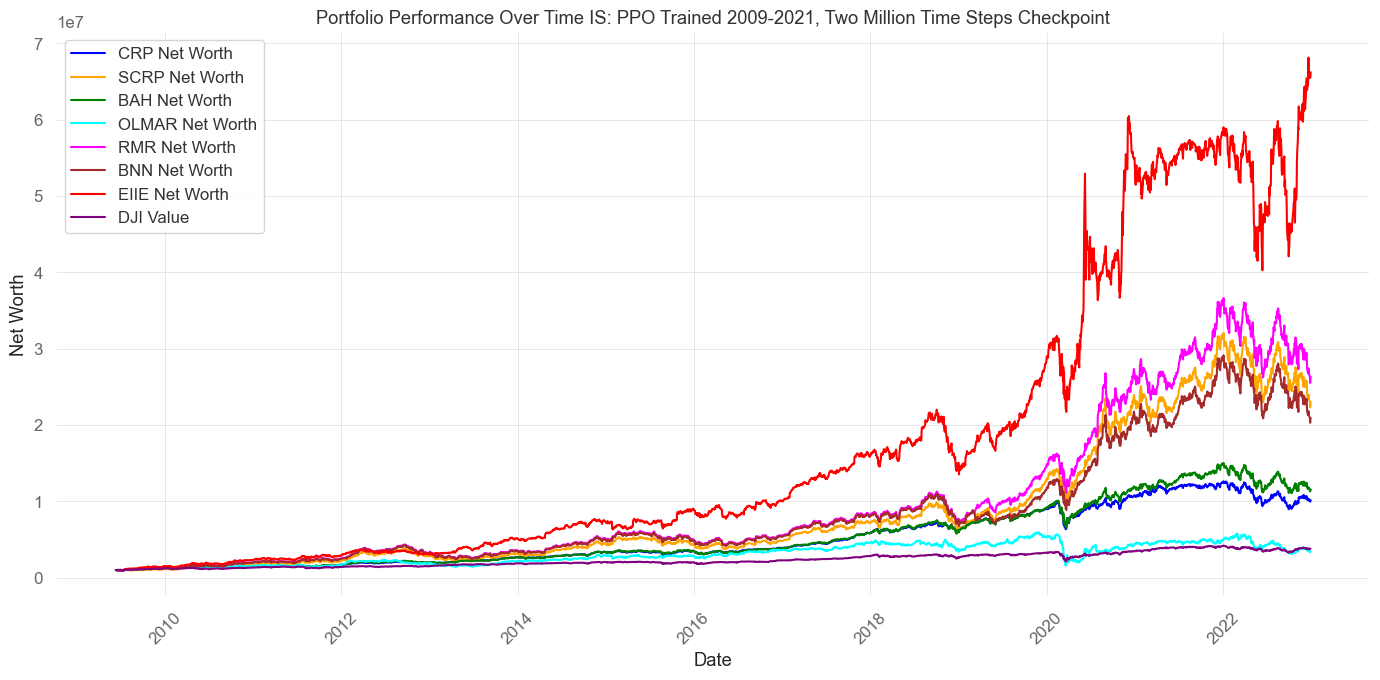

In [19]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

color_map = {
    'CRP Net Worth': 'blue',
    'BAH Net Worth': 'green',
    'EIIE Net Worth': 'red',
    'DJI Value': 'purple',
    'SCRP Net Worth': 'orange',
    'OLMAR Net Worth': 'cyan',
    'RMR Net Worth': 'magenta',
    'BNN Net Worth': 'brown'
}

plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth', color=color_map['CRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['scrp_opt_net_worth'], label='SCRP Net Worth', color=color_map['SCRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth', color=color_map['BAH Net Worth'])
plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR Net Worth', color=color_map['OLMAR Net Worth'])
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR Net Worth', color=color_map['RMR Net Worth'])
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN Net Worth', color=color_map['BNN Net Worth'])
plt.plot(merged_df['Date'], merged_df['eiie_net_worth'], label='EIIE Net Worth', color=color_map['EIIE Net Worth'])

plt.plot(merged_df['Date'], merged_df['dji'], label='DJI Value', color=color_map['DJI Value'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time IS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Final returns

import pprint

final_returns = {
   'BCRP': merged_df['bcrp_opt_net_worth'].iloc[-1],
   'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
   'SCRP': merged_df['scrp_opt_net_worth'].iloc[-1],
   'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
   'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
   'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
   'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
   'EIIE': merged_df['eiie_net_worth'].iloc[-1],
}

pprint.pprint(final_returns)

{'BAH': 11554503.0,
 'BCRP': 30495938.0,
 'BNN': 20909962.0,
 'CRP': 10140331.0,
 'EIIE': 66195320.0,
 'OLMAR': 3427245.0,
 'RMR': 26290140.0,
 'SCRP': 23013570.0}


In [21]:
import numpy as np

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['SCRP_opt_daily_return'] = merged_df['scrp_opt_net_worth'].pct_change()

merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()

merged_df['EIIE_daily_return'] = merged_df['eiie_net_worth'].pct_change()

# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'SCRP': calculate_sharpe_ratio(merged_df['SCRP_opt_daily_return'], risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),
    'EIIE': calculate_sharpe_ratio(merged_df['EIIE_daily_return'], risk_free_rate),
    # 'PPO': calculate_sharpe_ratio(merged_df['ppo_daily_return'], risk_free_rate),
    # 'TD3': calculate_sharpe_ratio(merged_df['td3_daily_return'], risk_free_rate)
}

pprint.pprint(sharpe_ratios)

{'BAH': 0.8685275250060522,
 'BCRP': 0.9563015276404229,
 'BNN': 0.8587428452031046,
 'CRP': 0.8533803732482588,
 'EIIE': 1.127853569610598,
 'OLMAR': 0.379130400213877,
 'RMR': 0.9170716082579607,
 'SCRP': 0.8819753305782094}


In [22]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'SCRP': max_drawdown(merged_df['scrp_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN': max_drawdown(merged_df['bnn_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
    'EIIE': max_drawdown(merged_df['eiie_net_worth']),
    # 'PPO': max_drawdown(merged_df['ppo_value']),
    # 'TD3': max_drawdown(merged_df['td3_value'])
}

pprint.pprint(max_drawdowns)


{'BAH': -0.3502311046638402,
 'BCRP': -0.43797166616468075,
 'BNN': -0.43797176696828877,
 'CRP': -0.3561145029001497,
 'EIIE': -0.3850119584929671,
 'OLMAR': -0.7357711266284152,
 'RMR': -0.43797197892335415,
 'SCRP': -0.43797179826158494}
